In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import import_ipynb
import Captcha_seg
import time

importing Jupyter notebook from Captcha_seg.ipynb


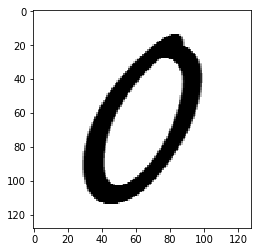

In [2]:
SEGMENTS_DIR = 'Segmented'
CAPTCHA_DIR = 'CAPTCHAS'
predictions = []
b_captcha = []

DATADIR = "./TrainImg/"
CATEGORIES= ["0","1","2","3","4","5","6","7","8","9","a","b","c","d","e","f","g","h","i","j","k","l","m","n","o","p","q","r","s","t","u","v","w","x","y","z"]
for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
        plt.imshow(img_array, cmap="gray")
        break
    break

In [3]:
print(img_array.shape)

(128, 128)


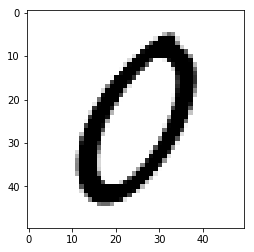

In [4]:
IMG_SIZE = 50

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap= 'gray')
plt.show()

In [5]:
train_data = []

def create_train_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category) 
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                train_data.append([new_array,class_num])
            except Exception as e:
                pass
            
create_train_data()

In [6]:
print(len(train_data))

36576


In [7]:
import random

random.shuffle(train_data)

In [8]:
for sample in train_data[:10]:
    print(sample[1])

1
32
18
23
19
17
7
26
7
13


In [9]:
X = []
y = []

In [10]:
for features, label in train_data:
    X.append(features)
    y.append(label)
    
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [11]:
import pickle

pickle_out = open("X.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()
pickle_out = open("y.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [12]:
pickle_in= open("X.pickle", "rb")
X = pickle.load(pickle_in)
X.shape[1:]

(50, 50, 1)

In [14]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout,Activation, Flatten, Conv2D, MaxPooling2D

X = pickle.load(open("X.pickle","rb"))
y = pickle.load(open("y.pickle","rb"))

X = X/255.0

model = Sequential()

model.add(Conv2D(64,(3,3),input_shape= X.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation("relu"))


model.add(Dense(36))
model.add(Activation("softmax"))

from keras.utils import to_categorical
y_binary = to_categorical(y)

model.compile(loss="categorical_crossentropy",
             optimizer="adam",
             metrics=['accuracy'])

model.fit(X,y_binary,batch_size=128, epochs=10, validation_split = 0.2)


Train on 29260 samples, validate on 7316 samples
Epoch 1/10
29260/29260 [==============================] - 152s 5ms/step - loss: 1.1327 - acc: 0.7052 - val_loss: 0.4770 - val_acc: 0.8762
Epoch 2/10
29260/29260 [==============================] - 151s 5ms/step - loss: 0.3418 - acc: 0.9077 - val_loss: 0.3011 - val_acc: 0.9188
Epoch 3/10
29260/29260 [==============================] - 155s 5ms/step - loss: 0.2374 - acc: 0.9332 - val_loss: 0.2663 - val_acc: 0.9245
Epoch 4/10
29260/29260 [==============================] - 154s 5ms/step - loss: 0.1777 - acc: 0.9478 - val_loss: 0.1854 - val_acc: 0.9442
Epoch 5/10
29260/29260 [==============================] - 152s 5ms/step - loss: 0.1365 - acc: 0.9590 - val_loss: 0.1621 - val_acc: 0.9508
Epoch 6/10
29260/29260 [==============================] - 152s 5ms/step - loss: 0.1077 - acc: 0.9666 - val_loss: 0.1663 - val_acc: 0.9517
Epoch 7/10
29260/29260 [==============================] - 150s 5ms/step - loss: 0.0882 - acc: 0.9741 - val_loss: 0.1291 - v

In [15]:
#model.summary()

In [17]:
def similarity(a,b):
    i =0
    for x,y in zip(a,b):
        if x==y:
            i+= 1
    percentage = (i/5) * 100
    return percentage

def prepare(filepath):
    IMG_SIZE = 50
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))
    #plt.imshow(new_array,'gray')
    return new_array.reshape(-1, IMG_SIZE,IMG_SIZE,1)

total_time = 0
score = 0
count = 0
for captchas in os.listdir(CAPTCHA_DIR):
    start_time = time.time()
    predict_list= []
    captcha_name = captchas.split('.')
    print('\n')
    print('Actual: ',captcha_name[0])
    
    captcha_path =os.path.join(CAPTCHA_DIR,captchas)
    Captcha_seg.segment(captcha_path)
    
    files = []
    for segments in os.listdir(SEGMENTS_DIR):
        files.append(segments)
        files.sort()
    
    for segments in files:
        filepath = os.path.join(SEGMENTS_DIR,segments)
        prediction = model.predict([prepare(filepath)])
        predict_list.append(CATEGORIES[np.argmax(prediction[0])])
    
    elapsed_time = time.time()-start_time
    total_time += elapsed_time
    final_prediction = ''.join(predict_list)
    if captcha_name[0]== final_prediction:
        score +=1
    
    print('Predicted:',final_prediction,'\n')
    print('Percentage Similarity= ',similarity(captcha_name[0],final_prediction))
    print('Elapsed time= ',elapsed_time,'s')
    print('<------------------------------->')    
    predictions.append(similarity(captcha_name[0],final_prediction))
    count += 1


print('Total number of CAPTCHAS broken: ',score)    
print('Total number of CAPTCHAS attempted: ',count)
avg_prediction = score/count
print('Average Characters Predicted= ',avg_prediction,'%')
print('Total time taken= ',total_time,'s')
#model = tf.keras.models.load_model('captcha_alpha.model')
#prediction = model.predict([prepare('3.png')])
#print(len(prediction[0]))
#print(prediction[0])
#print(CATEGORIES[np.argmax(prediction[0])])



Actual:  2mg87
Predicted: ihde7 

Percentage Similarity=  20.0
Elapsed time=  0.06528210639953613 s
<------------------------------->


Actual:  2fxgd
Predicted: zxxod 

Percentage Similarity=  40.0
Elapsed time=  0.014953851699829102 s
<------------------------------->


Actual:  2gyb6
Predicted: x67ke 

Percentage Similarity=  0.0
Elapsed time=  0.012299299240112305 s
<------------------------------->


Actual:  2g7nm
Predicted: ze7oh 

Percentage Similarity=  20.0
Elapsed time=  0.0113067626953125 s
<------------------------------->


Actual:  2cgyx
Predicted: 7ts54 

Percentage Similarity=  0.0
Elapsed time=  0.15341782569885254 s
<------------------------------->


Actual:  2cg58
Predicted: itd53 

Percentage Similarity=  20.0
Elapsed time=  0.03418731689453125 s
<------------------------------->


Actual:  2bg48
Predicted: xkka8 

Percentage Similarity=  20.0
Elapsed time=  0.018510818481445312 s
<------------------------------->


Actual:  2g783
Predicted: 7e783 

Percentage S